In [24]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [25]:
import numpy as np
import scipy as sp

print(f"NumPy version: {np.__version__}")
print(f"SciPy version: {sp.__version__}")

NumPy version: 1.24.4
SciPy version: 1.9.1


In [26]:
pip install numpy==1.24.4 --user

Note: you may need to restart the kernel to use updated packages.


In [27]:
# Step 2: Load the datasets

customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [28]:
# Step 3: Merge datasets
data = transactions.merge(customers, on="CustomerID")

In [29]:
# Step 4: Feature Engineering- Aggregate transaction data for each customer
customer_features = data.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total transaction value
    "Quantity": "sum",    # Total quantity purchased
}).reset_index()

In [30]:
# Add region data from Customers.csv
customer_features = customer_features.merge(customers[["CustomerID", "Region"]], on="CustomerID")

In [31]:
# Encode 'Region' as numerical data
region_mapping = {region: idx for idx, region in enumerate(customer_features["Region"].unique())}
customer_features["RegionEncoded"] = customer_features["Region"].map(region_mapping)

In [32]:
# Select features for clustering
X = customer_features[["TotalValue", "Quantity", "RegionEncoded"]]

In [33]:
# Step 5: Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [34]:
# Step 6: Determine optimal number of clusters using DB Index
db_scores = []
for k in range(2, 11):  # Test cluster sizes from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    db_score = davies_bouldin_score(X_scaled, labels)
    db_scores.append((k, db_score))

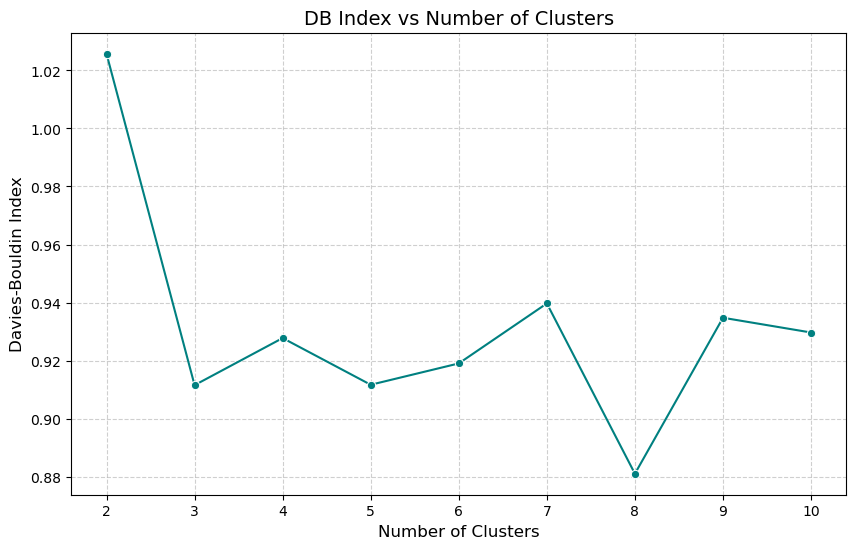

In [35]:
# Plot DB Index for different cluster sizes
plt.figure(figsize=(10, 6))
sns.lineplot(x=[k for k, _ in db_scores], y=[score for _, score in db_scores], marker="o", color="teal")
plt.title("DB Index vs Number of Clusters", fontsize=14)
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Davies-Bouldin Index", fontsize=12)
plt.grid(linestyle="--", alpha=0.6)
plt.show()

In [49]:
# Select the optimal number of clusters (lowest DB Index)
optimal_k = min(db_scores, key=lambda x: x[1])[0]


In [50]:
# Step 7: Perform clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features["Cluster"] = kmeans.fit_predict(X_scaled)

In [51]:
# Step 8: Visualize the clusters
num_clusters = customer_features["Cluster"].nunique()
colors = random.sample(sns.color_palette("Set3", n_colors=num_clusters), num_clusters)

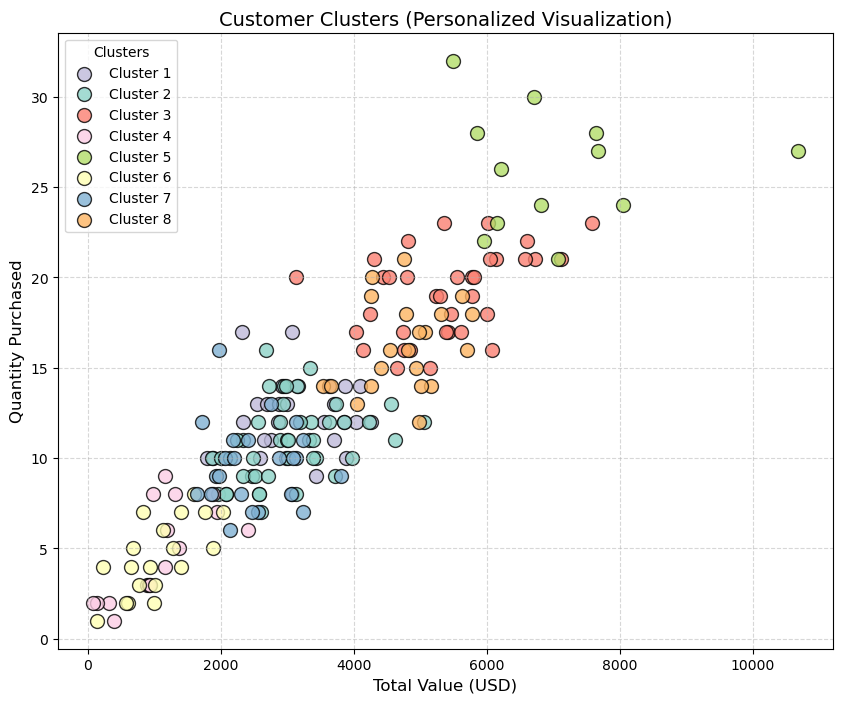

In [57]:
# Create a scatter plot for clusters
plt.figure(figsize=(10, 8))
for cluster_id in range(num_clusters):
    cluster_data = customer_features[customer_features["Cluster"] == cluster_id]
    plt.scatter(
        cluster_data["TotalValue"], cluster_data["Quantity"],
        color=colors[cluster_id],
        label=f"Cluster {cluster_id + 1}",
        edgecolor="black",
        s=100,
        alpha=0.8
    )
    
plt.title("Customer Clusters (Personalized Visualization)", fontsize=14)
plt.xlabel("Total Value (USD)", fontsize=12)
plt.ylabel("Quantity Purchased", fontsize=12)
plt.legend(title="Clusters", fontsize=10)
plt.grid(linestyle="--", alpha=0.5)
plt.show()

In [58]:
# Step 9: Save results to CSV
customer_features.to_csv("Customer_Clusters.csv", index=False)

In [62]:
# Step 10: Calculate additional clustering metrics
silhouette_avg = silhouette_score(X_scaled, customer_features["Cluster"])
print(f"Optimal number of clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {min(db_scores, key=lambda x: x[1])[1]:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")

Optimal number of clusters: 8
Davies-Bouldin Index: 0.8810
Silhouette Score: 0.3718
